# Continuous Control

---

In this notebook, you will learn how to use the Unity ML-Agents environment for the second project of the [Deep Reinforcement Learning Nanodegree](https://www.udacity.com/course/deep-reinforcement-learning-nanodegree--nd893) program.

### 1. Start the Environment

We begin by importing the necessary packages.  If the code cell below returns an error, please revisit the project instructions to double-check that you have installed [Unity ML-Agents](https://github.com/Unity-Technologies/ml-agents/blob/master/docs/Installation.md) and [NumPy](http://www.numpy.org/).

In [1]:
!pip -q install ./python

In [2]:
from unityagents import UnityEnvironment
from collections import namedtuple, deque
import numpy as np
import torch
import time
from ddpg_agent import Agent

import matplotlib.pyplot as plt
%matplotlib inline

The environments corresponding to both versions of the environment are already saved in the Udacity Workspace and can be accessed at the file paths provided below.  

Please select one of the two options below for loading the environment.

In [3]:
# select this option to load version 1 (with a single agent) of the environment
#env = UnityEnvironment(file_name='/data/Reacher_One_Linux_NoVis/Reacher_One_Linux_NoVis.x86_64')

# select this option to load version 2 (with 20 agents) of the environment
env = UnityEnvironment(file_name='/data/Reacher_Linux_NoVis/Reacher.x86_64')

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		goal_speed -> 1.0
		goal_size -> 5.0
Unity brain name: ReacherBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 33
        Number of stacked Vector Observation: 1
        Vector Action space type: continuous
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


Alternatively you can download the environment as follows:

In [4]:
#!wget -N https://s3-us-west-1.amazonaws.com/udacity-drlnd/P2/Reacher/Reacher_Linux_NoVis.zip
#!wget -N https://s3-us-west-1.amazonaws.com/udacity-drlnd/P2/Reacher/one_agent/Reacher_Linux_NoVis.zip
#!unzip Reacher_Linux_NoVis.zip
#!rm *.zip
#!chmod +x ./Reacher_Linux_NoVis/Reacher.x86_64

Next, we will start the environment!  **_Before running the code cell below_**, change the `file_name` parameter to match the location of the Unity environment that you downloaded.

- **Mac**: `"path/to/Reacher.app"`
- **Windows** (x86): `"path/to/Reacher_Windows_x86/Reacher.exe"`
- **Windows** (x86_64): `"path/to/Reacher_Windows_x86_64/Reacher.exe"`
- **Linux** (x86): `"path/to/Reacher_Linux/Reacher.x86"`
- **Linux** (x86_64): `"path/to/Reacher_Linux/Reacher.x86_64"`
- **Linux** (x86, headless): `"path/to/Reacher_Linux_NoVis/Reacher.x86"`
- **Linux** (x86_64, headless): `"path/to/Reacher_Linux_NoVis/Reacher.x86_64"`

For instance, if you are using a Mac, then you downloaded `Reacher.app`.  If this file is in the same folder as the notebook, then the line below should appear as follows:
```
env = UnityEnvironment(file_name="Reacher.app")
```

In [5]:
#env = UnityEnvironment(file_name='Reacher.app')

Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [6]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

### 2. Examine the State and Action Spaces

In this environment, a double-jointed arm can move to target locations. A reward of `+0.1` is provided for each step that the agent's hand is in the goal location. Thus, the goal of your agent is to maintain its position at the target location for as many time steps as possible.

The observation space consists of `33` variables corresponding to position, rotation, velocity, and angular velocities of the arm.  Each action is a vector with four numbers, corresponding to torque applicable to two joints.  Every entry in the action vector must be a number between `-1` and `1`.

Run the code cell below to print some information about the environment.

In [7]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents
num_agents = len(env_info.agents)
print('Number of agents:', num_agents)

# size of each action
action_size = brain.vector_action_space_size
print('Size of each action:', action_size)

# examine the state space 
states = env_info.vector_observations
state_size = states.shape[1]
print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))
print('The state for the first agent looks like:', states[0])

Number of agents: 20
Size of each action: 4
There are 20 agents. Each observes a state with length: 33
The state for the first agent looks like: [  0.00000000e+00  -4.00000000e+00   0.00000000e+00   1.00000000e+00
  -0.00000000e+00  -0.00000000e+00  -4.37113883e-08   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00  -1.00000000e+01   0.00000000e+00
   1.00000000e+00  -0.00000000e+00  -0.00000000e+00  -4.37113883e-08
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   5.75471878e+00  -1.00000000e+00
   5.55726624e+00   0.00000000e+00   1.00000000e+00   0.00000000e+00
  -1.68164849e-01]


### 3. Set Up Hyperparameters And Create The DDPG Agent

In [8]:
BATCH_SIZE = 128        # minibatch size
BUFFER_SIZE = int(1e5)  # replay buffer size
GAMMA = 0.99            # discount factor
TAU = 1e-3              # for soft update of target parameters
LR_ACTOR = 1e-4         # learning rate of the actor
LR_CRITIC = 1e-4        # learning rate of the critic
WEIGHT_DECAY = 0        # L2 weight decay
EPSILON_START = 1.0     # Starting value of noise scaling parameter
EPSILON_END=0.01        # Minimum allowed value of noise scaling parameter
EPSILON_DECAY = 1e-6    # Decay rate of noise scaling parameter

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

agent = Agent(num_agents, state_size, action_size, random_seed=0, 
              gamma=GAMMA, tau=TAU, epsilon_start=EPSILON_START, epsilon_end=EPSILON_END,
              epsilon_decay=EPSILON_DECAY, weight_decay=WEIGHT_DECAY, replay_buffer_size=BUFFER_SIZE,
              batch_size=BATCH_SIZE, lr_actor=LR_ACTOR, lr_critic=LR_CRITIC)

### 4. Train The DDPG Agent

In [9]:
def ddpg(n_episodes=1000, scores_window_len=100, target_score=30.0, target_score_time=100):
    scores_window = deque(maxlen=scores_window_len)
    all_scores = []
        
    for i_episode in range(1, n_episodes+1):
        env_info = env.reset(train_mode=True)[brain_name]      # reset the environment    
        states = env_info.vector_observations                  # get the current state (for each agent)
        scores = np.zeros(num_agents)                          # initialize the score (for each agent)
        agent.reset()
        
        t = time.time()
        while True:
            actions = agent.act(states)                        # select an action (for each agent)
            env_info = env.step(actions)[brain_name]           # send all actions to tne environment
            next_states = env_info.vector_observations         # get next state (for each agent)
            rewards = env_info.rewards                         # get reward (for each agent)
            dones = env_info.local_done                        # see if episode finished
            agent.step(states, actions, rewards, next_states, dones)
            states = next_states                               # roll over states to next time step
            scores += rewards                                  # update the score (for each agent)
            if np.any(dones):                                  # exit loop if episode finished
                break
        
        current_episode_avg_score = np.mean(scores)
        scores_window.append(current_episode_avg_score)
        all_scores.append(current_episode_avg_score)
        average_score = np.mean(scores_window)
        
        print('\rEpisode {}: Reward: Mean {:.2f}, Max: {:.2f}, Min: {:.2f} ... Average Reward {:.2f}   Time: {:.2f}'\
              .format(i_episode, current_episode_avg_score, np.max(scores), np.min(scores), average_score, time.time() - t))        
        
        #if i_episode % 10 == 0:
        #    torch.save(agent.actor_local.state_dict(), 'checkpoint_actor.pth')
        #    torch.save(agent.critic_local.state_dict(), 'checkpoint_critic.pth')
            
        if average_score >= target_score and len(scores_window) >= target_score_time:
            print('\nEnvironment solved in {:d} episodes!\tAverage Score: {:.2f}'.format(i_episode, average_score))            
            torch.save(agent.actor_local.state_dict(), 'actor_model.pth')
            torch.save(agent.critic_local.state_dict(), 'critic_model.pth')
            break            
            
    return all_scores

In [10]:
scores = ddpg()

Episode 1: Reward: Mean 0.53, Max: 1.52, Min: 0.00 ... Average Reward 0.53   Time: 19.44
Episode 2: Reward: Mean 0.59, Max: 1.55, Min: 0.00 ... Average Reward 0.56   Time: 19.75
Episode 3: Reward: Mean 0.90, Max: 2.11, Min: 0.11 ... Average Reward 0.67   Time: 19.60
Episode 4: Reward: Mean 0.85, Max: 2.35, Min: 0.12 ... Average Reward 0.72   Time: 19.89
Episode 5: Reward: Mean 1.07, Max: 2.01, Min: 0.27 ... Average Reward 0.79   Time: 19.79
Episode 6: Reward: Mean 1.75, Max: 3.93, Min: 0.34 ... Average Reward 0.95   Time: 20.04
Episode 7: Reward: Mean 2.13, Max: 4.42, Min: 1.00 ... Average Reward 1.12   Time: 20.11
Episode 8: Reward: Mean 1.80, Max: 2.67, Min: 0.81 ... Average Reward 1.20   Time: 20.69
Episode 9: Reward: Mean 2.02, Max: 3.34, Min: 0.64 ... Average Reward 1.29   Time: 20.26
Episode 10: Reward: Mean 2.11, Max: 4.96, Min: 0.44 ... Average Reward 1.38   Time: 19.99
Episode 11: Reward: Mean 2.10, Max: 3.61, Min: 0.50 ... Average Reward 1.44   Time: 20.23
Episode 12: Reward:

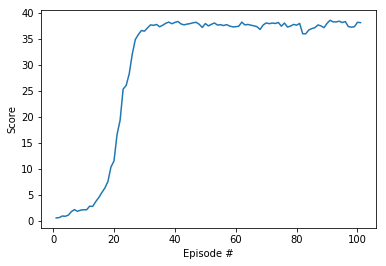

In [11]:
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(1, len(scores)+1), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

### 6. Load the saved agent and run it!

In [12]:
agent.actor_local.load_state_dict(torch.load('actor_model.pth'))
agent.critic_local.load_state_dict(torch.load('critic_model.pth'))

env_info = env.reset(train_mode=False)[brain_name]        
states = env_info.vector_observations                  
scores = np.zeros(num_agents)                          

for i in range(1000):
    actions = agent.act(states, 1.0)                    
    env_info = env.step(actions)[brain_name]        
    next_states = env_info.vector_observations        
    rewards = env_info.rewards                        
    dones = env_info.local_done                 
    scores += rewards                         
    states = next_states                              
    if np.any(dones):                              
        break
        
env.close()        